# This file is under Licence GPL v3. 
## You can use this file to make position over time graphs. Make sur to format you csv file (separate columns). 

In [32]:
#Importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [33]:
#Load the data
FILE = "001MoDe_R1.csv"
# Load full dataset
full_data = np.genfromtxt(FILE, delimiter=';', skip_header=3, names=True)
# Keep only the useful columns
blank = full_data[['timestamp', 'mouseX', 'mouseY', 'mouseInTarget']]



In [34]:
#print header of the files
with open(FILE, 'r', encoding='utf-8') as f:
    firstLine = f.readline().strip()

if firstLine : 
    data = firstLine.split(';')
    print("Head line information in 001MoDe_R1.csv:")
    for d in data : 
        print(" " + d.strip())

#print marker infos from line 4 to 26 and column 2 to 9
marker_file = "001MoDe_R1.marker.csv"
with open(marker_file, 'r', encoding='utf-8') as f:
    lines = f.readlines()[3:26]
    print("\nMarker information in 001MoDe_R1.marker.csv:")
    for line in lines:
        data = line.strip().split(';')[1:9]
        print(" ".join(data))

Head line information in 001MoDe_R1.csv:
 screenWidth 1104
 centerX 552
 centerY 330
 externalRadius 250
 internalRadius 170
 borderRadius 1
 cursorRadius 16
 indexOfDifficulty 28.00696429476858
 taskRadius 209.5
 taskTolerance 47
 borderColor java.awt.Color[r=255,g=255,b=255]
 backgroundColor java.awt.Color[r=0,g=0,b=0]
 cursorColorRecord java.awt.Color[r=255,g=0,b=0]
 cursorColorWait java.awt.Color[r=255,g=255,b=0]
 autoStart 3600
 cycleMaxNumber 6
 cycleDuration 20
 software LSL-mouse
 version 1.2.0rc5
 task CircularTarget
 isWithLSL false

Marker information in 001MoDe_R1.marker.csv:
17:38:32.325 1616776712325 KeyTyped=32 DoCycleChange    
17:38:32.331 1616776712331 DoCycleChange:DoStartCycleTimedSequence     
17:38:32.333 1616776712333 DoCycleChange:DoRecord RecordDone=0 PauseDone=0 ToDo=6  
17:38:52.336 1616776732336 DoCycleChange:DoPause RecordDone=1 PauseDone=0 ToDo=6  
17:39:12.340 1616776752340 DoCycleChange:DoRecord RecordDone=1 PauseDone=1 ToDo=6  
17:39:32.351 161677677235

In [35]:
# extract arrays
mX = np.array(blank['mouseX'], dtype=np.int64)
mY = np.array(blank['mouseY'], dtype=np.int64)
timestamp = np.array(blank['timestamp'], dtype=np.int64)

# Center coordinates reference
CENTER_X = 552
CENTER_Y = 330
Xc = mX - CENTER_X
Yc = mY - CENTER_Y

C:\Users\dvxya\AppData\Local\Temp\ipykernel_424\3418324804.py:2: RuntimeWarning: invalid value encountered in cast
  mX = np.array(blank['mouseX'], dtype=np.int64)
C:\Users\dvxya\AppData\Local\Temp\ipykernel_424\3418324804.py:3: RuntimeWarning: invalid value encountered in cast
  mY = np.array(blank['mouseY'], dtype=np.int64)


In [36]:
#seperate records 
def get_column(filepath, col="A", sep=","):
    col_index=0
    for char in col.upper():
        col_index = col_index * 26 + (ord(char) - ord('A') + 1)
    col_index -= 1

    values = []
    with open(filepath, "r", encoding = "utf-8") as f:
        lines = f.readlines()
    
    for line in lines:
        cols = line.strip().split(sep)
        if col_index < len(cols):
            values.append(cols[col_index])
        else:
            values.append("")
    return values

In [37]:
#apply records to time stamps: robust numpy-based detection + extractor
import numpy as np

def find_records(ts):
    ts_arr = np.asarray(ts, dtype=np.int64)
    if ts_arr.size == 0:
        return []

    mask = ts_arr != 0
    if not mask.any():
        return []

    edges = np.diff(mask.astype(int))
    starts = np.where(edges == 1)[0] + 1
    ends = np.where(edges == -1)[0] + 1

    if mask[0]:
        starts = np.concatenate(([0], starts)) if starts.size else np.array([0])
    if mask[-1]:
        ends = np.concatenate((ends, [len(mask)])) if ends.size else np.array([len(mask)])

    records = list(zip(starts.tolist(), ends.tolist()))
    return records

records = find_records(timestamp)
print(f'Found {len(records)} record(s): {records}')

def extract_record_times(start_idx, end_idx):
    """Return (T_rel_seconds, Xc_slice, Yc_slice, target_slice) for indices [start_idx:end_idx]."""
    t_slice = np.asarray(timestamp[start_idx:end_idx], dtype=np.int64)
    if t_slice.size == 0:
        return (np.array([]), np.array([]), np.array([]), np.array([]))
    T_rel = (t_slice - t_slice[0]) / 1000.0  # seconds relative to segment start
    Xc_slice = Xc[start_idx:end_idx]
    Yc_slice = Yc[start_idx:end_idx]
    target_slice = np.asarray(blank['mouseInTarget'])[start_idx:end_idx]
    return (T_rel, Xc_slice, Yc_slice, target_slice)

Found 5 record(s): [(0, 3972), (3973, 7871), (7872, 11770), (11771, 15655), (15656, 19592)]


## Display graphs for each detected record (X, Y, Target)

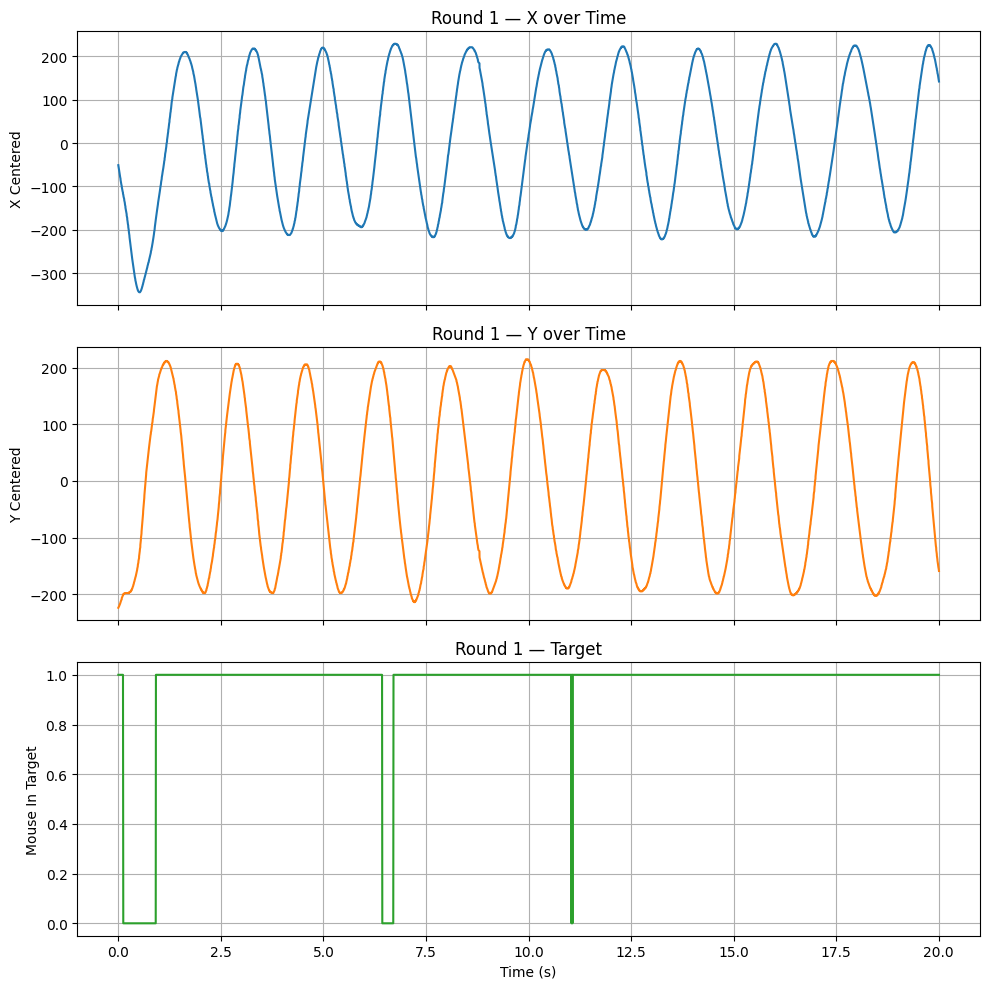

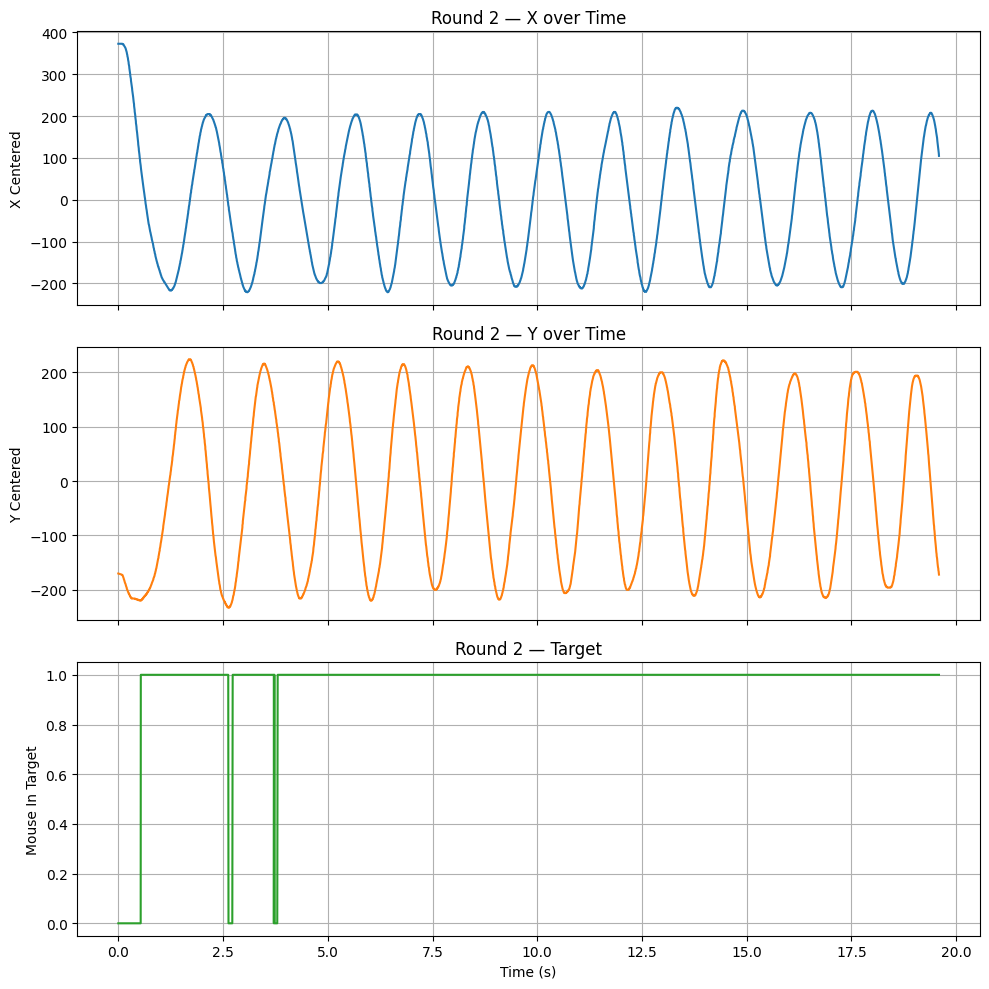

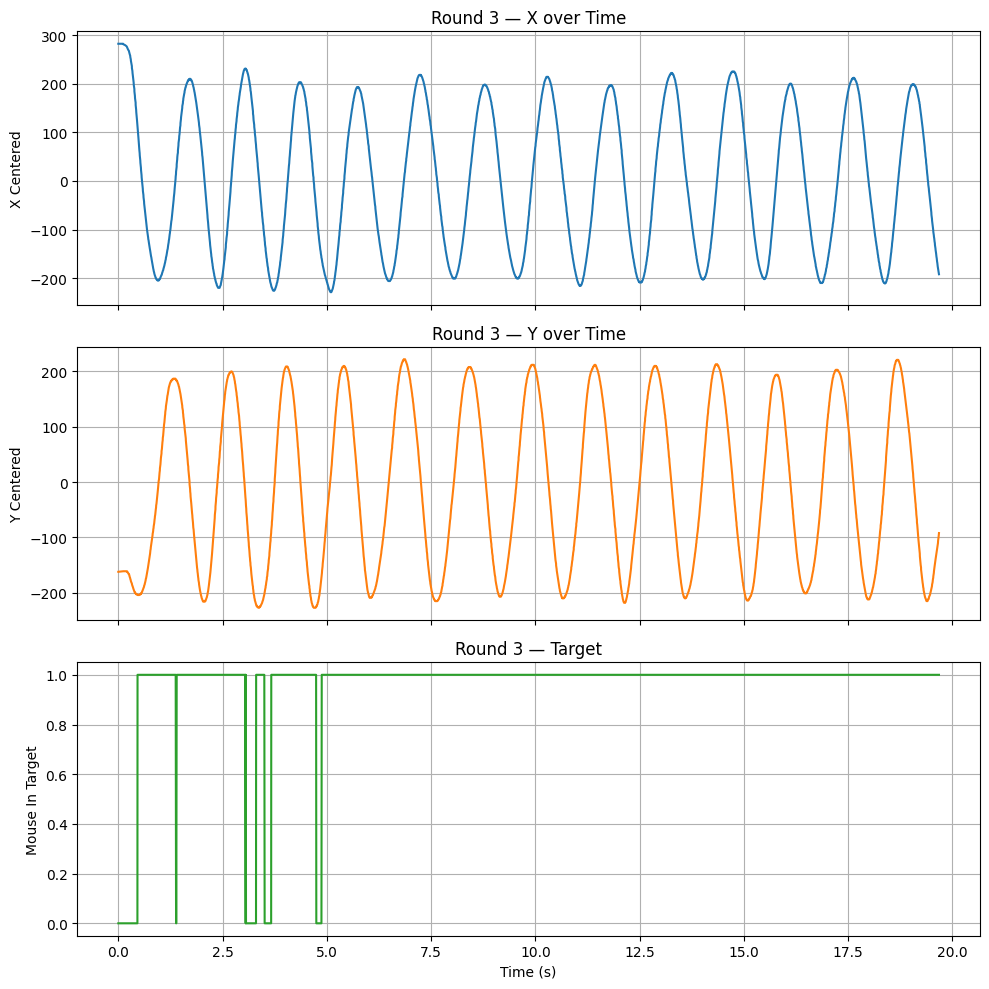

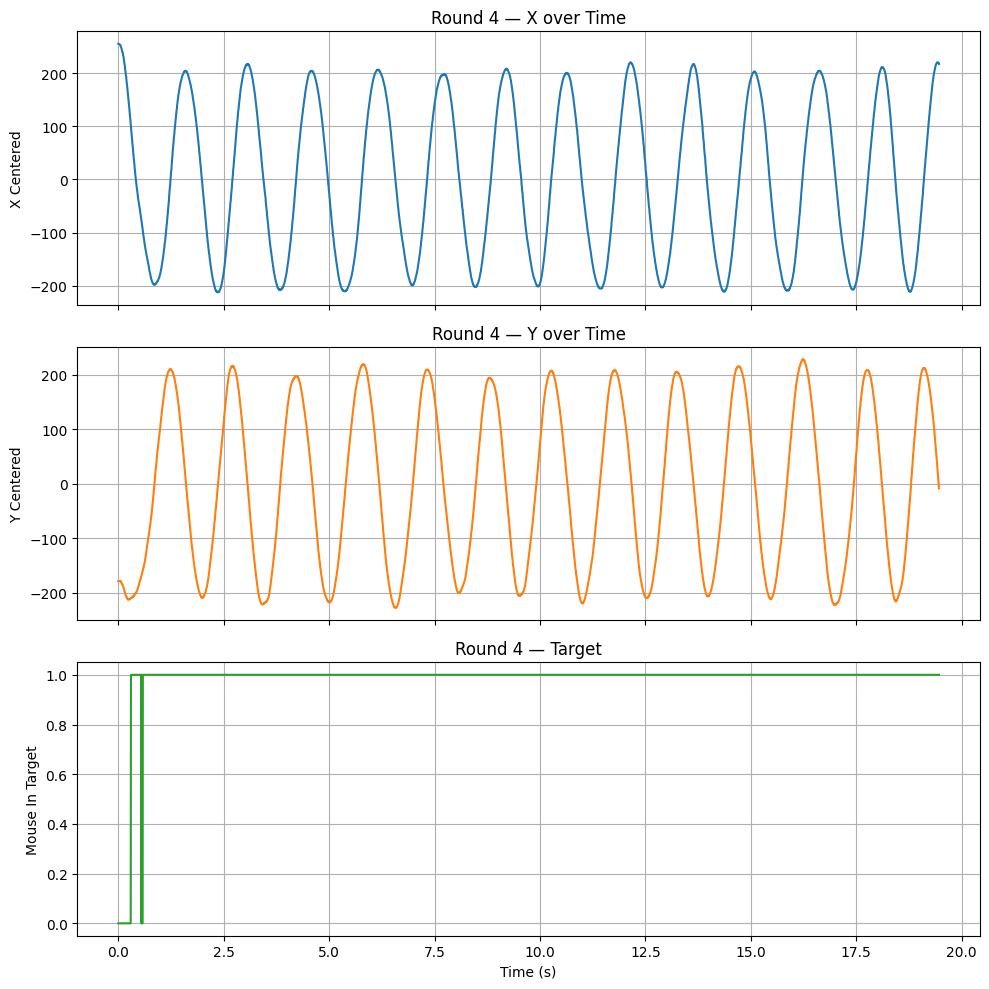

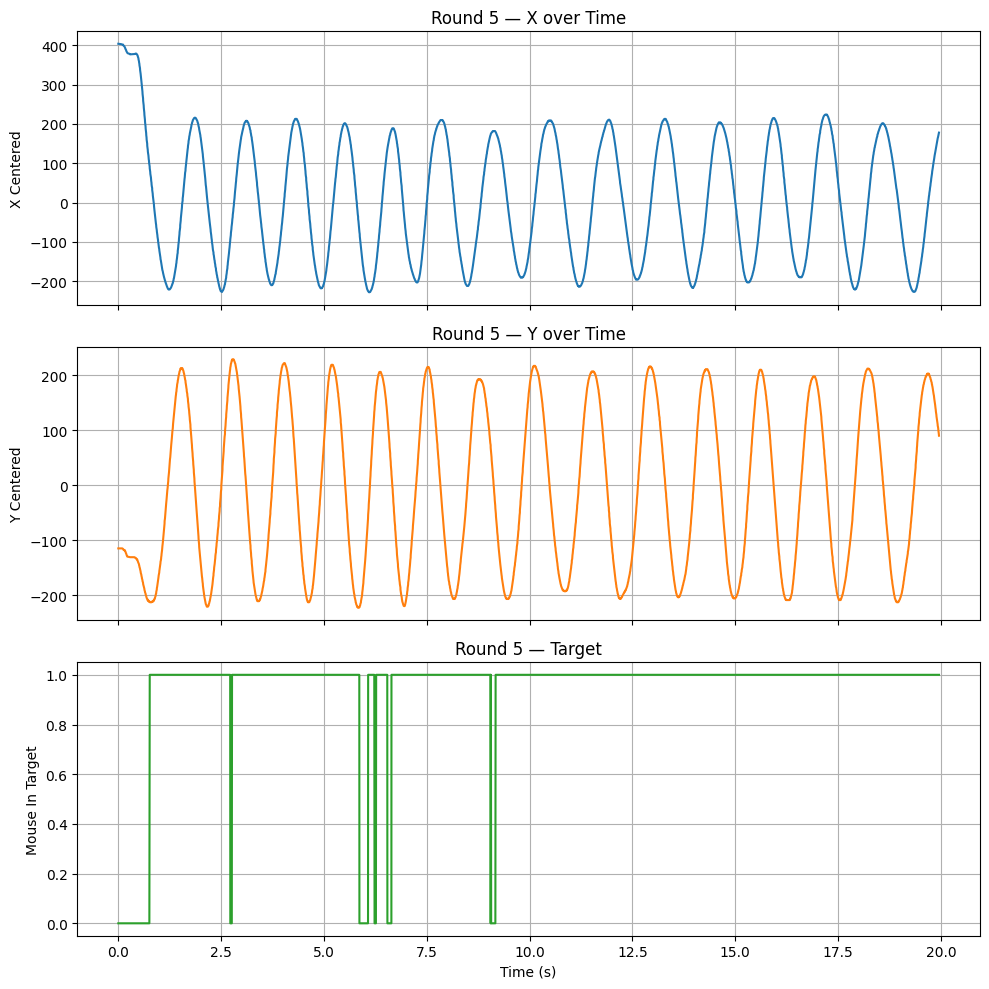

In [38]:
def plot_round(T, X, Y, target, round_number):
    """Plot three stacked subplots for a single round: X, Y (inverted for plotting), and target."""
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

    ax1.plot(T, X, color='tab:blue')
    ax1.set_ylabel('X Centered')
    ax1.set_title(f'Round {round_number} — X over Time')
    ax1.grid(True)

    ax2.plot(T, -Y, color='tab:orange')
    ax2.set_ylabel('Y Centered')
    ax2.set_title(f'Round {round_number} — Y over Time')
    ax2.grid(True)

    ax3.plot(T, target, color='tab:green')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Mouse In Target')
    ax3.set_title(f'Round {round_number} — Target')
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

# Ensure records exist
if 'records' not in globals():
    records = find_records(timestamp)

for i, (s, e) in enumerate(records, start=1):
    T_rel, Xc_slice, Yc_slice, target_slice = extract_record_times(s, e)
    # plot a 3-panel figure for this record
    plot_round(T_rel, Xc_slice, Yc_slice, target_slice, i)

# Optionally create rounds list for combined plotting later
rounds = [ (T, X, Y, trg) for (T, X, Y, trg) in (extract_record_times(s,e) for s,e in records) ]

### Display all curves in the same graph :

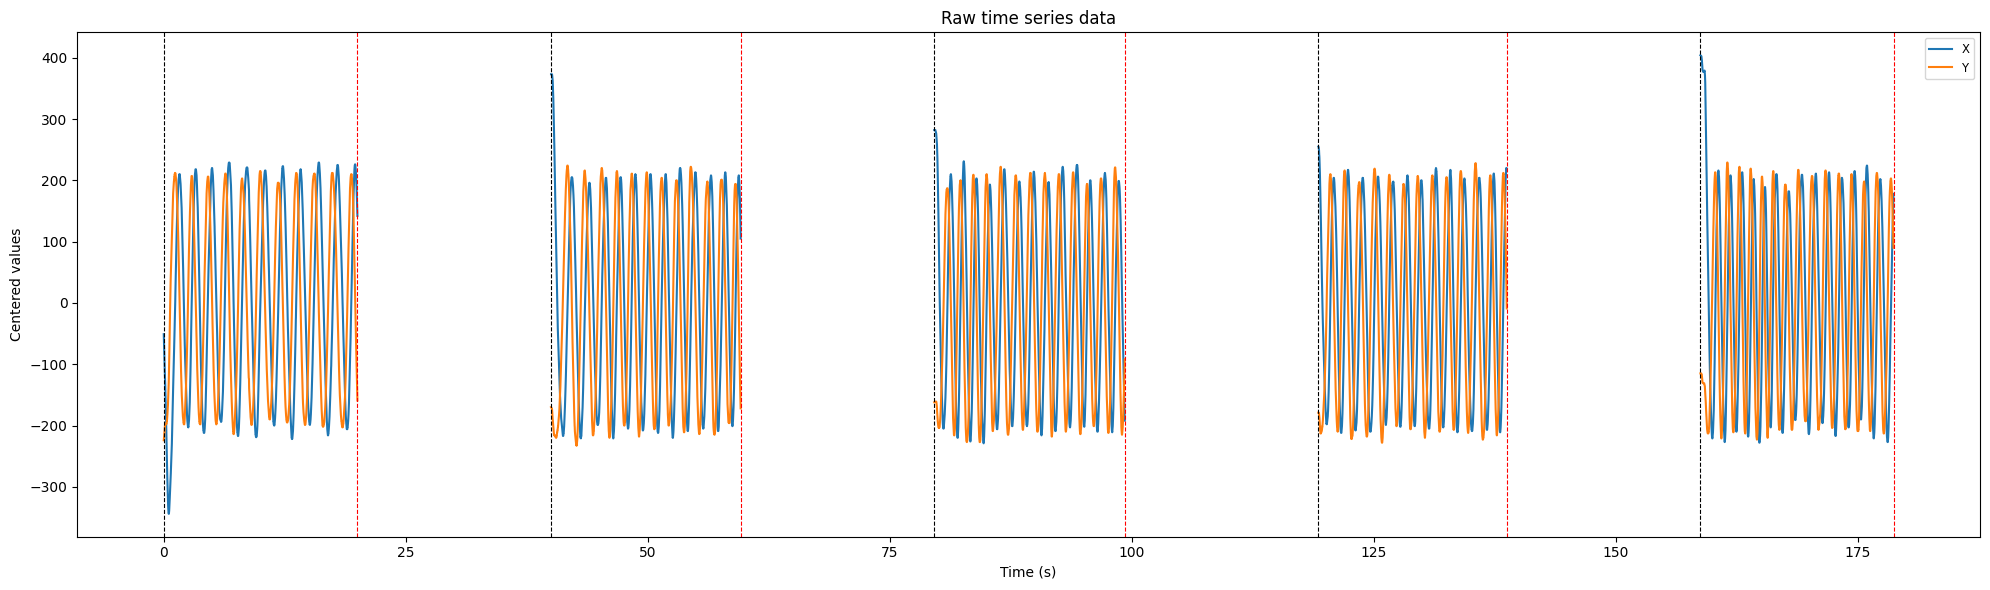

In [39]:
# Compute sequential offsets (seconds) with a 20.0s gap between rounds
start_offsets = []
current_offset = 0.0
gap_seconds = 20.0
for T, X, Y, trg in rounds:
    start_offsets.append(current_offset)
    dur = (T[-1] - T[0]) if len(T) > 0 else 0.0
    current_offset += dur + gap_seconds

fig, ax = plt.subplots(figsize=(20, 6))

# fixed colors for all records
color_x = 'tab:blue'
color_y = 'tab:orange'

for idx, ((T, X, Y, trg), offset) in enumerate(zip(rounds, start_offsets), start=1):
    # process_round returns T relative (starts at 0), so add offset
    T_plot = T + offset
    # label only for first round so legend shows single X and Y entries
    x_label = 'X' if idx == 1 else '_nolegend_'
    y_label = 'Y' if idx == 1 else '_nolegend_'

    ax.plot(T_plot, X, color=color_x, label=x_label, alpha=1)
    ax.plot(T_plot, -Y, color=color_y, label=y_label, alpha=1)

    # visual separators for round boundaries
    ax.axvline(offset, color='black', ls='--', lw=0.8)
    ax.axvline(offset + (T[-1] if len(T) else 0.0), color='red', ls='--', lw=0.8)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Centered values')
ax.set_title('Raw time series data')
ax.grid(False)
ax.legend(loc='upper right', fontsize='small')
plt.tight_layout()
plt.show()